In [290]:
import json
import matplotlib.pyplot as plt
import numpy as np
import math
import random

In [291]:
def importData(file):

    # open json file
    with open(file) as f:
        data = json.load(f)

    keys = [i for i in data.keys()]

    d_vectors = {}
    good_dict = {}

    for key in keys:

        d_vectors[key] = {}
        vectors = data[key]["vectors"]

        measurement = data[key]["attributes"]["measurement"]
        repetition = data[key]["attributes"]["repetition"]
        configs = data[key]["config"]
        mergedConfigs={}
        for config in configs:
            mergedConfigs.update(config)
        timeLimit = mergedConfigs["sim-time-limit"]

        d_vectors[key]["measurement"] = measurement
        d_vectors[key]["repetition"] = int(repetition)
        
        assert timeLimit.endswith('s'), "Time limit format is incorrect"
        timeLimit = timeLimit[:-1]  # Remove the 's' at the end
        d_vectors[key]["timeLimit"] = int(timeLimit)

        if not measurement in good_dict:
            good_dict[measurement] = []

        good_dict[measurement].append({})
        good_dict[measurement][-1]['repetition']=int(repetition)
        good_dict[measurement][-1]['timeLimit']=int(timeLimit)
        good_dict[measurement][-1]['modules']={}

        for a in vectors:

            module = a["module"]
            name = a["name"]

            if not module in d_vectors[key]:
                d_vectors[key][module] = {}

            if not module in good_dict[measurement][-1]['modules']:
                good_dict[measurement][-1]['modules'][module] = {}

            d_vectors[key][module][name] = {}

            d_vectors[key][module][name]["times"] = a["time"]
            d_vectors[key][module][name]["values"] = a["value"]

            good_dict[measurement][-1]['modules'][module][name] = {}
            good_dict[measurement][-1]['modules'][module][name]["times"] = a["time"]
            good_dict[measurement][-1]['modules'][module][name]["values"] = a["value"]



    return d_vectors,good_dict


d_vectors,good_dict = importData("../multicore_sched/simulations/test.json")

In [292]:
iterationvars=['meanGenerationTime','meanProcessDuration']
statistic='turnaroundTime:vector'

In [293]:
import colorsys

def getColors(numColors, numVariations):
    colors = []
    for i in range(numColors):
        base_hue = i / numColors  # Base hue for this color group
        colors.append([])
        for j in range(numVariations):
            # Introduce hue variation (±2.5% maximum from base hue)
            hue_variation = 0.2  # Adjust this value to control hue variation strength
            hue = (base_hue + ((j/numVariations) - 0.5) * hue_variation) % 1
            
            # Original brightness progression with modified parameters
            lightness = 0.4 + j/numVariations/2.5  # 0.4 to 0.8 lightness range
            saturation = 0.8 - j/numVariations/4  # 0.7 to 0.45 saturation range
            
            colors[i].append(colorsys.hls_to_rgb(
                hue, 
                lightness, 
                saturation
            ))
    return colors

def showColors():
    # Plot colors
    fig, ax = plt.subplots(figsize=(numVariations, numColors))
    for i, row in enumerate(colors):
        for j, color in enumerate(row):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))

    ax.set_xlim(0, numVariations)
    ax.set_ylim(0, numColors)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    plt.show()
# showColors()


# # Usage remains the same
# numColors = len(measurements)
# numVariations = numRepetitions
# colors = getColors(numColors, numVariations)

In [294]:

def avg_and_std(values):
    average = np.average(values)
    # Biased variance
    variance = np.average((values-average)**2)
    return (average, np.sqrt(variance))

def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    # Biased variance
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

def find_nearest_small_value(key, sorted_li):
    less=[i for i in sorted_li if i <= key]
    if len(less)==0:
        return 0
    else:
        return len(less)-1

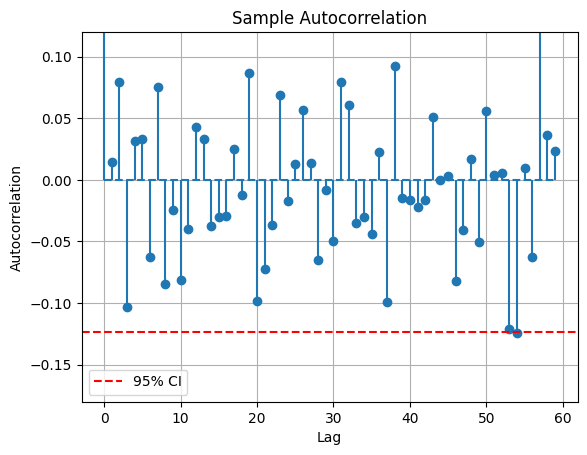

h: 30, Q: 23.8465791025761
Outside interval: 2, 0.7936507936507936%
Outside interval: 2, 2.0202020202020203%
Now the number of samples is: 253


In [ ]:
def autocorrelation(sample):
    # Step 1: Compute the mean and standard deviation
    mean = np.mean(sample)
    std_dev = np.std(sample)
    
    # Step 2: Normalize the sample
    normalized_sample = (sample - mean) / std_dev
    
    # Step 3: Compute the autocorrelation using numpy.correlate
    autocorr = np.correlate(normalized_sample, normalized_sample, mode='full')
    
    # The result is symmetric, so we take the second half
    autocorr = autocorr[len(autocorr)//2:]
    
    # Normalize the autocorrelation values
    autocorr /= autocorr[0]
    
    return autocorr

names=["$meanGenerationTime=50ms, $meanProcessDuration=150ms","$meanGenerationTime=50ms, $meanProcessDuration=200ms"]

testToUse=names[1]

# statistic='numBusyCpus:vector'
statistic='turnaroundTime:vector'

values = good_dict[testToUse][0]['modules']["Computer.scheduler"][statistic]["values"]

p=1/2**6

new_values=[]

for value in values:
    rand=np.random.uniform()
    if rand<p:
        new_values.append(value)

values=new_values


avg, std = avg_and_std(values)

# Calculate autocorrelation
autocorr_values = autocorrelation(values)

stop=60
lags=range(0,stop)

plt.stem(lags,autocorr_values[0:stop],basefmt="--")  # Stem plot for autocorrelation
plt.title(f"Sample Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

# plt.ylim(top=max(autocorr_values[1:]*1.2))
plt.ylim(top=0.12)


# Add horizontal lines at ±1.96/sqrt(n)
n = len(values)  # Sample size
confidence_interval = 1.96 / np.sqrt(n)
plt.axhline(y=confidence_interval, color='r', linestyle='--', label='95% CI')
plt.axhline(y=-confidence_interval, color='r', linestyle='--')

plt.grid(True)
plt.legend()
plt.show()


#Ljung–Box test

h=30

Q=0
n=len(values)

for i in range(1,h):
    Q+=n*(n+2)*(autocorr_values[i]**2)/(n-i)

print(f"h: {h}, Q: {Q}")

# Calculate number of values outside confidence interval

outside=0


test_values=autocorr_values[1:]

for value in test_values:
    if value > confidence_interval or value < -confidence_interval:
        outside+=1

print(f"Outside interval: {outside}, {100*outside/len(test_values)}%")

# Calculate number of values outside confidence interval near

outside=0
stop=100

test_values=autocorr_values[1:stop]

for value in test_values:
    if value > confidence_interval or value < -confidence_interval:
        outside+=1

print(f"Outside interval: {outside}, {100*outside/len(test_values)}%")

print(f"Now the number of samples is: {len(values)}")

In [296]:
from statsmodels.stats.diagnostic import acorr_ljungbox

def statsModelIndependence(values):
    result = acorr_ljungbox(values, lags=30)
    Qs=result.iloc[:,0]
    pvalues=result.iloc[:,1]
    return Qs,pvalues

def testIndependence(values,sigLevel=0.05):
    Qs,pvalues=statsModelIndependence(values)
    return all(pvalues>sigLevel)
# testIndependence(values)


def makeValuesIndependent(values):
    k=0
    j=0

    testvalues=values.copy()

    while not testIndependence(testvalues):

        j+=1

        if j==3:
            k+=1
            j=0
        p=1/2**k

        random.seed(j)

        testvalues=[]

        for value in values:
            rand=random.random()
            if rand<p:
                testvalues.append(value)
        
    print(f"At the end k={k}, number of samples is: {len(testvalues)}")

    return testvalues


At the end k=5, number of samples is: 546


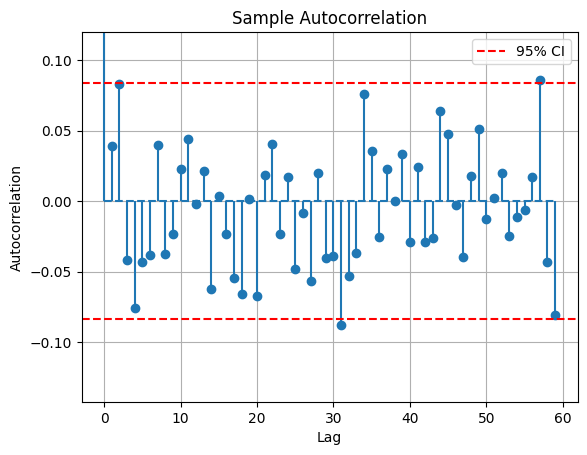

In [297]:
# testToUse=names[1]

values = good_dict[testToUse][0]['modules']["Computer.scheduler"][statistic]["values"]

values= makeValuesIndependent(values)

avg, std = avg_and_std(values)

# Calculate autocorrelation
autocorr_values = autocorrelation(values)

stop=60
lags=range(0,stop)

plt.stem(lags,autocorr_values[0:stop],basefmt="--")  # Stem plot for autocorrelation
plt.title(f"Sample Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

# plt.ylim(top=max(autocorr_values[1:]*1.2))
plt.ylim(top=0.12)


# Add horizontal lines at ±1.96/sqrt(n)
n = len(values)  # Sample size
confidence_interval = 1.96 / np.sqrt(n)
plt.axhline(y=confidence_interval, color='r', linestyle='--', label='95% CI')
plt.axhline(y=-confidence_interval, color='r', linestyle='--')

plt.grid(True)
plt.legend()
plt.show()


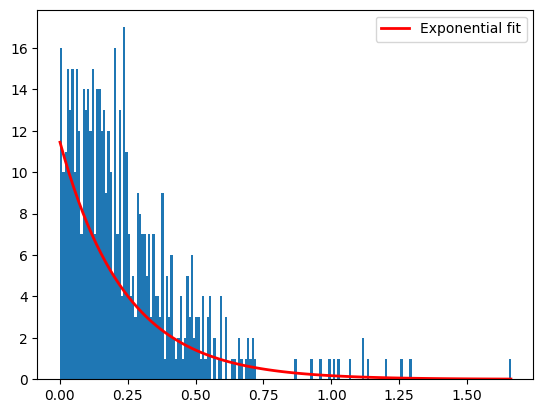

In [298]:
from scipy.stats import expon

#histogram of values
bins=200
plt.hist(values,bins=bins)

#plot also a exponential curve
# Fit an exponential distribution to the data
loc, scale = expon.fit(values)

# Generate the x values for the exponential curve
x = np.linspace(min(values), max(values), 100)

# Plot the exponential curve
plt.plot(x, len(values)/bins*expon.pdf(x, loc, scale), 'r-', lw=2, label='Exponential fit')
plt.legend()
plt.show()


In [299]:
#qq plot
import scipy.stats as stats

# Generate a QQ plot
# fig, ax = plt.subplots()
res=stats.probplot(values, dist="expon", sparams=(loc, scale))

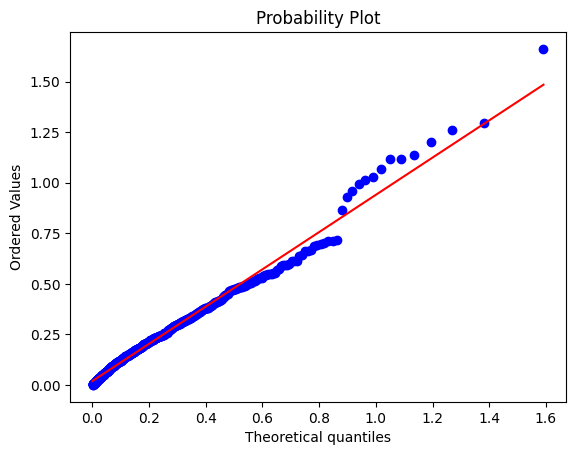

In [306]:
#plot 1 quantile for each 10 available

step=1
# step=len(values)//20

# Generate a QQ plot with step
fig, ax = plt.subplots()
res = stats.probplot(values[::step], dist="expon", sparams=(loc, scale), plot=ax)
plt.show()

In [301]:
from scipy.stats import bootstrap

In [302]:
def stdDev(values):
    return np.std(values)
def mean(values):
    return np.mean(values)

Confidence interval for mean: 0.22213979768769984 to 0.25839366773648303
Confidence interval for mean: 0.1943015662389818 to 0.2546460118380059


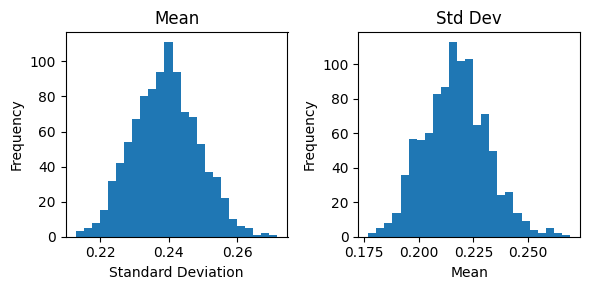

In [303]:
data = (values,)  # samples must be in a sequence

# Bootstrap for mean
res_mean = bootstrap(data, mean, n_resamples=999, confidence_level=0.95)
low, high = res_mean.confidence_interval
print(f"Confidence interval for mean: {low} to {high}")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
ax[0].hist(res_mean.bootstrap_distribution, bins=25)
ax[0].set_title('Mean')
ax[0].set_xlabel('Standard Deviation')
ax[0].set_ylabel('Frequency')

# Bootstrap for std dev
res_dev = bootstrap(data, stdDev, n_resamples=999, confidence_level=0.95)
low, high = res_dev.confidence_interval
print(f"Confidence interval for mean: {low} to {high}")

ax[1].hist(res_dev.bootstrap_distribution, bins=25)
ax[1].set_title('Std Dev')
ax[1].set_xlabel('Mean')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



In [304]:
sampMean, sampStd = avg_and_std(values)

confLef=sampMean-1.96*sampStd/np.sqrt(len(values))
confRig=sampMean+1.96*sampStd/np.sqrt(len(values))

print(f"Confidence interval: {confLef} to {confRig}")

Confidence interval: 0.22087802844804588 to 0.2574581237089761


In [305]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt

nsample = 100

rng = np.random.default_rng()